In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import os
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import Pipeline

from sklearn.compose import ColumnTransformer



In [3]:
df = pd.read_csv("C:\\Users\\nagar\\OneDrive\\Desktop\\unified mentor\\Projects\\fraud_detection\\fruad_detection\\notebooks\\Base.csv")

In [4]:
df.shape

(1000000, 32)

In [5]:
df.head()

,fraud_bool,income,name_email_similarity,prev_address_months_count,current_address_months_count,customer_age,days_since_request,intended_balcon_amount,payment_type,zip_count_4w,...,has_other_cards,proposed_credit_limit,foreign_request,source,session_length_in_minutes,device_os,keep_alive_session,device_distinct_emails_8w,device_fraud_count,month
0,0,0.3,0.986506,-1,25,40,0.006735,102.453711,AA,1059,...,0,1500.0,0,INTERNET,16.224843,linux,1,1,0,0
1,0,0.8,0.617426,-1,89,20,0.010095,-0.849551,AD,1658,...,0,1500.0,0,INTERNET,3.363854,other,1,1,0,0
2,0,0.8,0.996707,9,14,40,0.012316,-1.490386,AB,1095,...,0,200.0,0,INTERNET,22.730559,windows,0,1,0,0
3,0,0.6,0.475100,11,14,30,0.006991,-1.863101,AB,3483,...,0,200.0,0,INTERNET,15.215816,linux,1,1,0,0
4,0,0.9,0.842307,-1,29,40,5.742626,47.152498,AA,2339,...,0,200.0,0,INTERNET,3.743048,other,0,1,0,0


In [6]:
df.columns

Index(['fraud_bool', 'income', 'name_email_similarity',
       'prev_address_months_count', 'current_address_months_count',
       'customer_age', 'days_since_request', 'intended_balcon_amount',
       'payment_type', 'zip_count_4w', 'velocity_6h', 'velocity_24h',
       'velocity_4w', 'bank_branch_count_8w',
       'date_of_birth_distinct_emails_4w', 'employment_status',
       'credit_risk_score', 'email_is_free', 'housing_status',
       'phone_home_valid', 'phone_mobile_valid', 'bank_months_count',
       'has_other_cards', 'proposed_credit_limit', 'foreign_request', 'source',
       'session_length_in_minutes', 'device_os', 'keep_alive_session',
       'device_distinct_emails_8w', 'device_fraud_count', 'month'],
      dtype='object')

| **Feature Name**                  | **Meaning**                                                                 |
|----------------------------------|------------------------------------------------------------------------------|
| `fraud_bool`                     | 1 = fraud, 0 = not fraud. This is what your model will learn to predict.    |
| `income`                         | The person’s income. Lower or very high income might show different fraud risk. |
| `name_email_similarity`          | How similar the person’s name is to the email. Fake profiles often use mismatched names and emails. |
| `prev_address_months_count`      | How long the person stayed at the previous address (in months). Fraudsters often change addresses quickly. |
| `current_address_months_count`   | Time spent at the current address. Longer = more stable.                    |
| `customer_age`                   | Age of the customer. Certain fraud patterns target specific age groups.     |
| `days_since_request`             | Days passed since the loan/account/etc. was requested.                      |
| `intended_balcon_amount`         | The amount the person wants (loan amount, maybe). Larger amounts are higher risk. |
| `payment_type`                   | How the payment will be made (e.g., credit card, bank transfer). Some types are riskier. |
| `zip_count_4w`                   | Number of people with same ZIP code in last 4 weeks. High number = maybe multiple fake accounts. |
| `velocity_6h` / `24h` / `4w`     | Number of transactions in that time frame. High velocity = suspicious behavior (like bots). |
| `bank_branch_count_8w`           | How many bank branches this person interacted with in last 8 weeks.         |
| `date_of_birth_distinct_emails_4w` | How many different emails used with same DOB — if high, might be identity theft. |
| `employment_status`              | Job status (Employed, Unemployed, Student, etc.).                           |
| `credit_risk_score`              | A score that tells how likely this person will repay money. Lower = risky.  |
| `email_is_free`                  | Is the email from a free service (like Gmail/Yahoo)? Free = easier to fake. |
| `housing_status`                 | Owns home, rents, etc.                                                      |
| `phone_home_valid`               | Is the home phone number valid?                                             |
| `phone_mobile_valid`             | Is the mobile number valid?                                                 |
| `bank_months_count`              | How long the person has had their bank account. New accounts = higher risk. |
| `has_other_cards`                | Does the person have other credit cards? Might reduce risk (or increase, based on pattern). |
| `proposed_credit_limit`          | Requested credit limit. Again, high values = potential risk.                |
| `foreign_request`                | Was the request made from a foreign country? Often suspicious.              |
| `source`                         | Where the request came from (mobile app, website, etc.).                    |
| `session_length_in_minutes`      | How long the session lasted. Very short sessions might be bots.             |
| `device_os`                      | What OS the user used (Windows, Android, etc.). Can help detect automated devices. |
| `keep_alive_session`             | Whether the session stayed alive (auto-refreshing).                         |
| `device_distinct_emails_8w`      | How many different emails used the same device in 8 weeks — common for fraud. |
| `device_fraud_count`             | How many times this device has been linked to past frauds. Very powerful feature. |
| `month`                          | The calendar month of the request. Fraud may spike during certain seasons (sales, festivals, etc.). |


In [7]:
df.fraud_bool.value_counts()

fraud_bool
0    988971
1     11029
Name: count, dtype: int64

In [8]:
df.rename(columns={
    'name_email_similarity': 'name_email_match_score',
    
    'prev_address_months_count': 'prev_address_duration',

    'current_address_months_count': 'curr_address_duration',

    'intended_balcon_amount': 'intended_loan_amount',

    'zip_count_4w': 'zip_activity_4w',

    'velocity_6h': 'tx_velocity_6h',

    'velocity_24h': 'tx_velocity_24h',

    'velocity_4w': 'tx_velocity_4w',

    'date_of_birth_distinct_emails_4w': 'dob_unique_emails_4w',

    'bank_branch_count_8w': 'branches_used_8w',

    'email_is_free': 'is_free_email',

    'keep_alive_session': 'session_auto_active',

    'device_distinct_emails_8w': 'device_unique_emails_8w',

    'device_fraud_count': 'device_fraud_history',
    
    'fraud_bool': 'fraud',

    'customer_age': 'age',
    
    'credit_risk_score': 'credit_score',
}, inplace=True)


In [9]:
## Check the metadata

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 32 columns):
 #   Column                     Non-Null Count    Dtype  
---  ------                     --------------    -----  
 0   fraud                      1000000 non-null  int64  
 1   income                     1000000 non-null  float64
 2   name_email_match_score     1000000 non-null  float64
 3   prev_address_duration      1000000 non-null  int64  
 4   curr_address_duration      1000000 non-null  int64  
 5   age                        1000000 non-null  int64  
 6   days_since_request         1000000 non-null  float64
 7   intended_loan_amount       1000000 non-null  float64
 8   payment_type               1000000 non-null  object 
 9   zip_activity_4w            1000000 non-null  int64  
 10  tx_velocity_6h             1000000 non-null  float64
 11  tx_velocity_24h            1000000 non-null  float64
 12  tx_velocity_4w             1000000 non-null  float64
 13  branches_used

In [10]:
## Checking for missing values

df.isnull().sum()

fraud                        0
income                       0
name_email_match_score       0
prev_address_duration        0
curr_address_duration        0
age                          0
days_since_request           0
intended_loan_amount         0
payment_type                 0
zip_activity_4w              0
tx_velocity_6h               0
tx_velocity_24h              0
tx_velocity_4w               0
branches_used_8w             0
dob_unique_emails_4w         0
employment_status            0
credit_score                 0
is_free_email                0
housing_status               0
phone_home_valid             0
phone_mobile_valid           0
bank_months_count            0
has_other_cards              0
proposed_credit_limit        0
foreign_request              0
source                       0
session_length_in_minutes    0
device_os                    0
session_auto_active          0
device_unique_emails_8w      0
device_fraud_history         0
month                        0
dtype: i

In [11]:
df.duplicated().sum()

np.int64(0)

<Axes: xlabel='fraud', ylabel='count'>

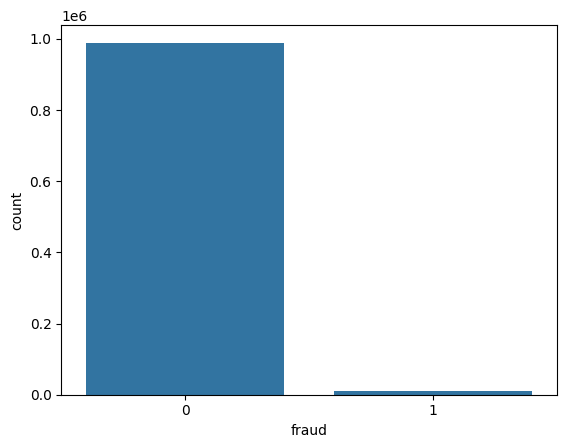

In [12]:
sns.countplot(data=df, x='fraud')

**We can clearly see that this data is highly imbalanced containing 988971 records for non-fraud (0) transactions and 11029 records for fraud (1) transactions.**

Q. What is Imbalanced Dataset?
- Dataset in which the classes or categories are not represented equally

Q. What problems are caused by highly Imbalanced dataset?
- Biased Model Predictions – The model becomes biased towards the majority class and fails to correctly classify the minority class.
- Poor Recall for Minority Class – The model might achieve high accuracy but perform poorly in detecting the minority class (high false negatives).
- Misleading Performance Metrics – Accuracy can be deceptive; a model predicting only the majority class can still have high accuracy but be useless for real-world applications.

***We will use Under Sampling method to make it balanced. We will take 11029 records for fraud (1) transactions and 11029 records for non-fraud (0) transactions***

And use this new data frame for model building

In [13]:
non_fruad = df[df['fraud'] != 1]
fruad = df[df['fraud'] == 1]

print("Shape of dataframe containing normal (non-fraud) transactions : ",non_fruad.shape) # Display the number of normal and fraud transactions
print("Shape of dataframe containing fraud transactions : ",fruad.shape)    

Shape of dataframe containing normal (non-fraud) transactions :  (988971, 32)
Shape of dataframe containing fraud transactions :  (11029, 32)


In [14]:
from sklearn.utils import resample
non_fruad_under_sample = resample(non_fruad,replace=False,n_samples = len(fruad),random_state=27)

print("Shape of undersampled normal transactions : ",non_fruad_under_sample.shape)

Shape of undersampled normal transactions :  (11029, 32)


In [15]:
new_df = pd.concat([non_fruad_under_sample,fruad])
new_df.fraud.value_counts()

fraud
0    11029
1    11029
Name: count, dtype: int64

In [16]:
new_df.to_csv('data.csv', index = False) 

In [17]:
df = pd.read_csv('data.csv')

In [18]:
df.drop(columns=['tx_velocity_4w'], axis=1, inplace=True)

df.head(3)

,fraud,income,name_email_match_score,prev_address_duration,curr_address_duration,age,days_since_request,intended_loan_amount,payment_type,zip_activity_4w,...,has_other_cards,proposed_credit_limit,foreign_request,source,session_length_in_minutes,device_os,session_auto_active,device_unique_emails_8w,device_fraud_history,month
0,0,0.2,0.030287,-1,73,20,0.025534,-1.466167,AD,1762,...,0,200.0,0,INTERNET,4.229294,windows,0,1,0,3
1,0,0.2,0.138368,-1,236,10,0.008773,-1.344937,AB,745,...,0,200.0,0,INTERNET,13.421658,linux,0,1,0,1
2,0,0.8,0.018937,-1,85,30,0.012032,31.286179,AA,4922,...,1,200.0,0,INTERNET,3.836661,other,1,1,0,0


In [19]:
payment_type = ["AB","AA","AC","AD","AE"]
employment_type = ["CA","CB","CF","CC","CD","CE","CG"]
housing_type = ["BC", "BB", "BA", "BE", "BD","BF","BG"]
source_type = ["TELEAPP", "INTERNET"]
device_type = ["x11", "macintosh", "windows", "linux", "other"]

In [20]:
num_pipeline = Pipeline(
    steps=[
        ("imputer",SimpleImputer(strategy="median")),
        ('scaler',RobustScaler())
    ]
)


cat_pipeline = Pipeline(
    steps=[
        ("imputer",SimpleImputer(strategy="most_frequent")),
        ("encoder",OrdinalEncoder(categories=[payment_type, employment_type, housing_type, source_type, device_type]))

    ]
)


In [21]:
X = df.drop(columns=['fraud'],axis=1)
y = df['fraud']

In [22]:
num_cols = X.select_dtypes(exclude='object').columns
cat_cols = X.select_dtypes(include='object').columns

In [23]:
print(num_cols)

Index(['income', 'name_email_match_score', 'prev_address_duration',
       'curr_address_duration', 'age', 'days_since_request',
       'intended_loan_amount', 'zip_activity_4w', 'tx_velocity_6h',
       'tx_velocity_24h', 'branches_used_8w', 'dob_unique_emails_4w',
       'credit_score', 'is_free_email', 'phone_home_valid',
       'phone_mobile_valid', 'bank_months_count', 'has_other_cards',
       'proposed_credit_limit', 'foreign_request', 'session_length_in_minutes',
       'session_auto_active', 'device_unique_emails_8w',
       'device_fraud_history', 'month'],
      dtype='object')


In [24]:
print(cat_cols)

Index(['payment_type', 'employment_status', 'housing_status', 'source',
       'device_os'],
      dtype='object')


In [25]:
preprocessor = ColumnTransformer(
    [
        ("num_pipeline",num_pipeline,num_cols),
        ("cat_pipeline",cat_pipeline,cat_cols)
    ]
)

In [26]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=12)


In [27]:
X.head()

,income,name_email_match_score,prev_address_duration,curr_address_duration,age,days_since_request,intended_loan_amount,payment_type,zip_activity_4w,tx_velocity_6h,...,has_other_cards,proposed_credit_limit,foreign_request,source,session_length_in_minutes,device_os,session_auto_active,device_unique_emails_8w,device_fraud_history,month
0,0.2,0.030287,-1,73,20,0.025534,-1.466167,AD,1762,5745.520659,...,0,200.0,0,INTERNET,4.229294,windows,0,1,0,3
1,0.2,0.138368,-1,236,10,0.008773,-1.344937,AB,745,6020.282729,...,0,200.0,0,INTERNET,13.421658,linux,0,1,0,1
2,0.8,0.018937,-1,85,30,0.012032,31.286179,AA,4922,9182.473655,...,1,200.0,0,INTERNET,3.836661,other,1,1,0,0
3,0.9,0.362729,176,5,30,0.012527,-1.347402,AC,1832,6381.767483,...,0,200.0,0,INTERNET,13.115193,other,1,1,0,2
4,0.1,0.575680,-1,16,20,0.014657,-0.778923,AB,2071,5157.228784,...,0,200.0,0,INTERNET,2.779552,other,0,1,0,4


In [28]:
X_train.shape

(15440, 30)

In [29]:
X_train.columns

Index(['income', 'name_email_match_score', 'prev_address_duration',
       'curr_address_duration', 'age', 'days_since_request',
       'intended_loan_amount', 'payment_type', 'zip_activity_4w',
       'tx_velocity_6h', 'tx_velocity_24h', 'branches_used_8w',
       'dob_unique_emails_4w', 'employment_status', 'credit_score',
       'is_free_email', 'housing_status', 'phone_home_valid',
       'phone_mobile_valid', 'bank_months_count', 'has_other_cards',
       'proposed_credit_limit', 'foreign_request', 'source',
       'session_length_in_minutes', 'device_os', 'session_auto_active',
       'device_unique_emails_8w', 'device_fraud_history', 'month'],
      dtype='object')

In [30]:
X_test.shape

(6618, 30)

In [31]:
y_train.head()

8879     0
13671    1
18354    1
716      0
6851     0
Name: fraud, dtype: int64

In [32]:
preprocessor.fit_transform(X_train)
preprocessor.transform(X_test)


array([[ 0.2       ,  0.44223148,  0.        , ...,  0.        ,
         1.        ,  4.        ],
       [ 0.2       , -0.52675574, 33.        , ...,  0.        ,
         1.        ,  3.        ],
       [ 0.4       ,  0.06825354,  0.        , ...,  2.        ,
         0.        ,  4.        ],
       ...,
       [ 0.2       ,  1.05452888,  0.        , ...,  2.        ,
         1.        ,  2.        ],
       [-1.        ,  0.85890103,  0.        , ...,  0.        ,
         1.        ,  2.        ],
       [-0.2       , -0.50604931,  0.        , ...,  0.        ,
         1.        ,  2.        ]], shape=(6618, 30))

In [33]:
X_train = pd.DataFrame(preprocessor.fit_transform(X_train),columns=preprocessor.get_feature_names_out())
X_test=pd.DataFrame(preprocessor.transform(X_test),columns=preprocessor.get_feature_names_out())

In [34]:
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score,f1_score,precision_score

In [ ]:
## Define the models

models={

    'LogisticRegression':LogisticRegression(),
    'Randomforest':RandomForestClassifier(),
    'xgboost':XGBClassifier()
}

In [ ]:
trained_model_list=[]
model_list=[]
acc_list=[]
f1_list = []
precision_list = []

In [ ]:
def evaluate_model(true,pred):
    acc=accuracy_score(true,pred)
    f1=f1_score(true,pred)
    p_score=precision_score(true,pred)

    return acc, f1, p_score

In [ ]:
for i in range(len(list(models))):
    model=list(models.values())[i]
    
    model.fit(X_train,y_train)

    #make_prediction
    y_pred=model.predict(X_test)

    #this is for the validaiton
    acc, f1, p_score = evaluate_model(y_test,y_pred)